In [1]:
# Install required packages that are not part of the default environment
!pip install pycm livelossplot -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.4/610.4 kB 13.7 MB/s eta 0:00:00


In [51]:

import random
import time
import math
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from livelossplot import PlotLosses
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
def set_seed(seed: int = 42):
    """
    Sets the random seed for the entire environment to ensure reproducibility.
    This function sets seeds for random, numpy, and torch, and configures
    CUDA settings for deterministic behavior.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Set seed for all GPUs
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CuDNN
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True # Use deterministic instead of disabling cudnn
    return True

# --- Set the master seed for the notebook ---
SEED = 42
set_seed(SEED)

# --- Configure compute device (GPU or CPU) ---
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(" Cuda installed! Running on GPU:", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("No GPU available! Running on CPU.")

Random seed set to 42
No GPU available! Running on CPU.


mount google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


load training data

In [20]:
train_data = pd.read_csv('/content/gdrive/MyDrive/data/train.csv')

test_data = pd.read_csv('/content/gdrive/MyDrive/data/test.csv')

In [21]:
train_data.head(5)

,id,demand,date,temp_1,temp_night_1,wind_1,wind_night_1,ssrd_ratio_1,temp_2,temp_night_2,...,temp_12,temp_night_12,wind_12,wind_night_12,ssrd_ratio_12,temp_13,temp_night_13,wind_13,wind_night_13,ssrd_ratio_13
0,2,248.551330,2009-01-01,0.493500,-0.024375,2.337942,0.960386,0.834858,-0.324375,-0.064167,...,-2.363625,-0.754208,1.748286,0.438337,1.240712,-2.409958,-0.800167,2.200373,0.762233,0.915315
1,3,242.671902,2009-01-02,0.707125,-0.772042,3.241219,0.933666,1.585796,1.011167,-0.496917,...,-0.279708,-0.677500,1.826779,0.590232,1.514933,-0.316625,-0.612000,3.044197,0.997103,1.165282
2,4,251.157507,2009-01-03,-1.296292,-1.071583,2.420432,1.173104,1.424222,-0.819917,-0.821917,...,-1.832542,-1.051208,1.238009,0.766633,1.572659,-3.518542,-1.978167,1.580882,0.578175,1.793391
3,5,260.073426,2009-01-04,-0.899583,-0.257417,3.756638,1.464167,1.067949,-0.197667,0.194583,...,-0.315917,-0.044708,2.237830,0.961864,0.613913,-1.496042,-0.720583,2.173770,0.862646,0.792718
4,6,277.125461,2009-01-05,-0.905250,-1.125292,4.416067,1.288584,1.503319,-0.249708,-0.721083,...,-1.375833,-1.417083,2.134971,0.617133,1.443376,-1.569000,-1.572250,3.726705,1.006098,1.227480


In [22]:
def fix_date(df):
    """Converts 'date' column to datetime and sets it as a sorted index."""
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

# Apply the preprocessing to both train and test dataframes for consistency
train_df = fix_date(train_data)
test_df = fix_date(test_data)

print("'date' column is now the index.")

'date' column is now the index.


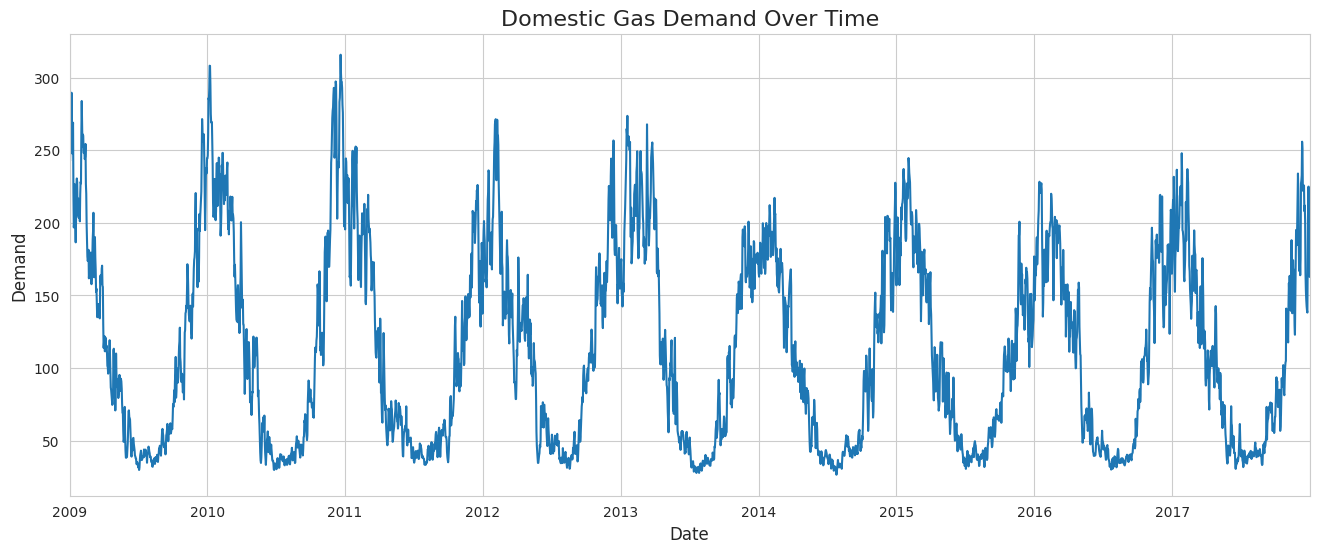

In [29]:
plt.figure(figsize=(16, 6))
train_df['demand'].plot()
plt.title('Domestic Gas Demand Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.show()


since demand is cyclic, well do some more feature engineering so the model knows this.

another feature engineering- getting the average of weather data across the 13 locations

In [26]:
# Define the weather features to be aggregated
weather_features = ['temp', 'temp_night', 'wind', 'wind_night', 'ssrd_ratio']

# Iterate through each weather feature to create an average value
for feature in weather_features:
    # Dynamically find all columns related to the feature (e.g., 'temp_1', 'temp_2', ...)
    related_cols = [col for col in train_df.columns if col.startswith(f'{feature}_')]

    # Calculate the mean across these columns and create a new 'avg_' column
    train_df[f'avg_{feature}'] = train_df[related_cols].mean(axis=1)
    # Do the same for the test set to maintain feature parity
    test_df[f'avg_{feature}'] = test_df[related_cols].mean(axis=1)


print("Created new aggregated weather features.")
train_df.shape

Created new aggregated weather features.


(3287, 72)

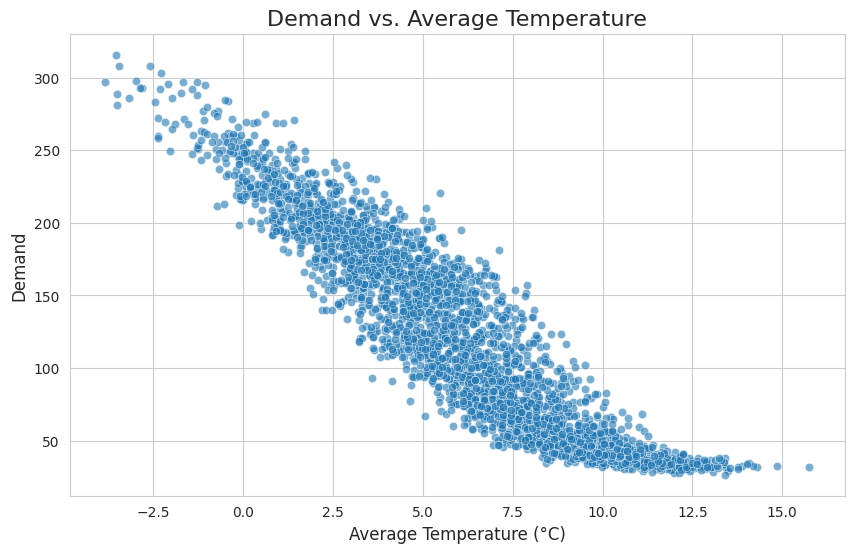

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temp', y='demand', data=train_data, alpha=0.6)
plt.title('Demand vs. Average Temperature', fontsize=16)
plt.xlabel('Average Temperature (°C)', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.show()

demand goes up as tempreature goes down- as expected.

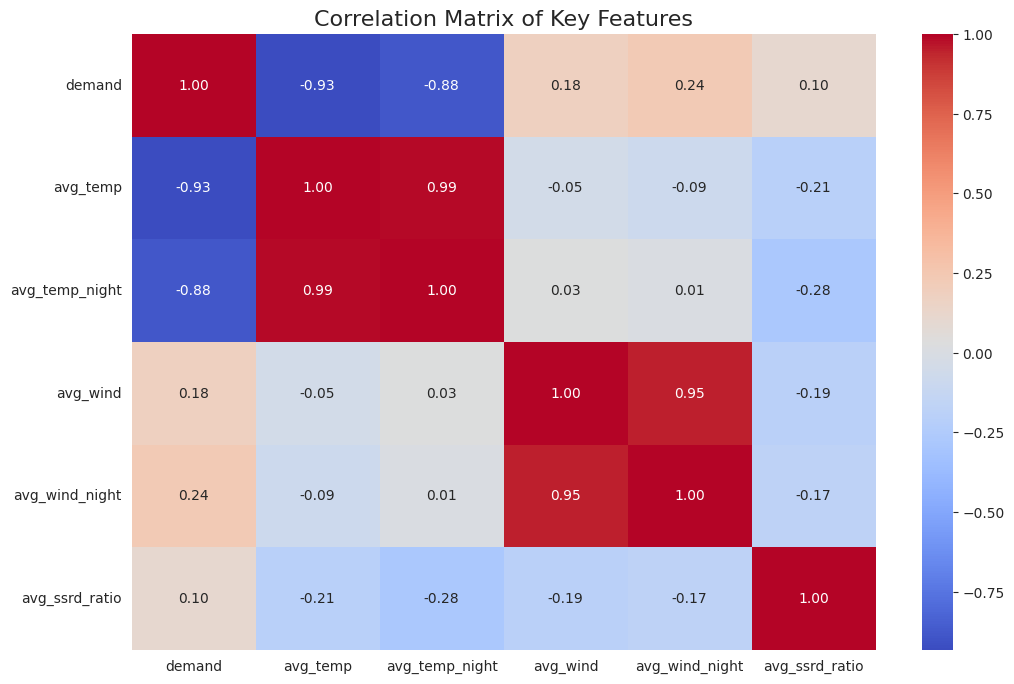

In [30]:
plt.figure(figsize=(12, 8))
# Select only the demand and our new aggregated features for clarity
correlation_features = ['demand', 'avg_temp', 'avg_temp_night', 'avg_wind', 'avg_wind_night', 'avg_ssrd_ratio']
correlation_matrix = train_df[correlation_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features', fontsize=16)
plt.show()

**Multicollinearity:** avg_tempandavg_temp_nightare highly correlated with each other. Similarly,avg_windandavg_wind_night are highly correlated - im not dropping anything since theres still some variancer corelation with demand and this is a deep learning model. would have dropped 2 columns if i was doing ML.

In [33]:
train_df.head(6)

,id,demand,temp_1,temp_night_1,wind_1,wind_night_1,ssrd_ratio_1,temp_2,temp_night_2,wind_2,...,temp_13,temp_night_13,wind_13,wind_night_13,ssrd_ratio_13,avg_temp,avg_temp_night,avg_wind,avg_wind_night,avg_ssrd_ratio
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,2,248.551330,0.493500,-0.024375,2.337942,0.960386,0.834858,-0.324375,-0.064167,2.000167,...,-2.409958,-0.800167,2.200373,0.762233,0.915315,-0.213654,-0.112096,1.486299,0.838810,0.911825
2009-01-02,3,242.671902,0.707125,-0.772042,3.241219,0.933666,1.585796,1.011167,-0.496917,2.662331,...,-0.316625,-0.612000,3.044197,0.997103,1.165282,0.111482,-0.395891,1.837417,0.899566,1.428215
2009-01-03,4,251.157507,-1.296292,-1.071583,2.420432,1.173104,1.424222,-0.819917,-0.821917,2.765365,...,-3.518542,-1.978167,1.580882,0.578175,1.793391,-1.258934,-1.007218,1.710146,0.997601,1.601823
2009-01-04,5,260.073426,-0.899583,-0.257417,3.756638,1.464167,1.067949,-0.197667,0.194583,3.864623,...,-1.496042,-0.720583,2.173770,0.862646,0.792718,-0.202881,-0.070106,2.114267,1.236173,1.056973
2009-01-05,6,277.125461,-0.905250,-1.125292,4.416067,1.288584,1.503319,-0.249708,-0.721083,3.477253,...,-1.569000,-1.572250,3.726705,1.006098,1.227480,-1.116702,-1.200865,2.256914,1.037092,1.485264
2009-01-06,7,289.650452,-3.315792,-1.518667,2.674851,1.203864,1.717545,-1.888083,-0.308292,2.608287,...,-4.449167,-2.057083,1.984095,0.766895,1.697324,-1.727013,-0.980603,2.026515,1.127173,1.731351


In [38]:
# --- Model & Data Hyperparameters ---
SEQUENCE_LENGTH = 30  # How many previous time steps to use to predict the next one.
BATCH_SIZE = 32
INPUT_SIZE = 9        # The number of features used for prediction
HIDDEN_SIZE = 100
NUM_LAYERS = 2
OUTPUT_SIZE = 1
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.1
VALIDATION_SPLIT = 0.2 # Use the last 20% of the data for validation

In [35]:


def create_sequences(data, sequence_length):
    """Converts scaled data into sequences for the LSTM model."""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Target is the first column ('demand')
    return np.array(X), np.array(y)


def prepare_data_for_training(df, sequence_length, val_split_ratio):
    """
    Performs all preprocessing on the raw training dataframe:
    1. Creates aggregated and cyclical features.
    2. Selects the final feature set.
    3. Splits data chronologically into training and validation sets.
    4. Scales the data based ONLY on the training set statistics.
    5. Creates sequences and PyTorch DataLoaders.
    """

    # --- 1. Feature Engineering ---
    processed_df = df.copy()

    # b) Create cyclical time-based features
    processed_df['day_of_year_sin'] = np.sin(2 * np.pi * processed_df.index.dayofyear / 365.25)
    processed_df['month_sin'] = np.sin(2 * np.pi * processed_df.index.month / 12)
    processed_df['day_of_week_sin'] = np.sin(2 * np.pi * processed_df.index.dayofweek / 7)

    # --- 2. Feature Selection ---
    features_to_use = [
        'demand', 'avg_temp', 'avg_temp_night', 'avg_wind',
        'avg_wind_night', 'avg_ssrd_ratio', 'day_of_year_sin',
        'month_sin', 'day_of_week_sin'
    ]
    final_df = processed_df[features_to_use]
    print(f"Selected {len(features_to_use)} features for the model.")

    # --- 3. Chronological Train/Validation Split ---
    split_index = int(len(final_df) * (1 - val_split_ratio))
    train_split_df = final_df.iloc[:split_index]
    val_split_df = final_df.iloc[split_index:]
    print(f"Data split chronologically: {len(train_split_df)} training samples, {len(val_split_df)} validation samples.")

    # --- 4. Scaling (Fit on training data ONLY) ---
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit the scaler on the training data and transform it
    scaled_train_data = scaler.fit_transform(train_split_df)
    # Use the SAME scaler to transform the validation data
    scaled_val_data = scaler.transform(val_split_df)

    # --- 5. Create Sequences ---
    X_train, y_train = create_sequences(scaled_train_data, sequence_length)
    X_val, y_val = create_sequences(scaled_val_data, sequence_length)
    print(f"Created {(X_train.shape)} shape training sequences.")
    # --- 6. Create PyTorch DataLoaders ---
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().view(-1, 1))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data for better learning

    val_dataset = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().view(-1, 1))
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle validation data

    print("--- Data Preparation Complete ---")

    # Return the dataloaders AND the scaler for later use on the test set
    return train_loader, val_loader, scaler


#  get final training and validation data loaders
train_loader, val_loader, scaler = prepare_data_for_training(train_df, SEQUENCE_LENGTH, VALIDATION_SPLIT)

Selected 9 features for the model.
Data split chronologically: 2629 training samples, 658 validation samples.
Created (2599, 30, 9) shape training sequences.
--- Data Preparation Complete ---


the sequance has 30 less rows than the original size of the data because 30 days are being used to make 1 prediction.

In [50]:

class LSTMModel_Baseline(nn.Module):
    """
    The original LSTM model architecture.

    Regularization is applied only via the 'dropout' parameter within the
    nn.LSTM layer itself.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel_Baseline, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        # dropout is applied between LSTM layers only if num_layers > 1.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)

        #  fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """Defines the forward pass of the model."""
        # initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # pass input through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # take the output from the last timestep and pass it to the final layer
        out = self.fc(out[:, -1, :])

        return out

I tried hyper parameter tuning but it didnt make much of a difference so i tried changing the model a little.

In [54]:
class LSTMModel_CombinedDropout(nn.Module):
    """
    An LSTM model that combines two types of dropout for strong regularization.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMModel_CombinedDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # dropout 1: applied BETWEEN stacked LSTM layers (if num_layers > 1)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)

        # Dropout 2: applied AFTER the final LSTM output and BEFORE the linear layer
        self.dropout = nn.Dropout(dropout_rate)

        #  final fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """Defines the forward pass of the model."""
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # model layer's internal dropout (Method 1) is applied here
        out, _ = self.lstm(x, (h0, c0))

        # take the output from the last timestep and apply the second dropout (Method 2)
        out = self.dropout(out[:, -1, :])

        # pass the regularized output to the final layer
        out = self.fc(out)

        return out

In [52]:
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    """
    A reusable function to train and validate a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        optimizer: The optimizer for the model.
        criterion: The loss function.
        train_loader (DataLoader): DataLoader for the training set.
        val_loader (DataLoader): DataLoader for the validation set.
        num_epochs (int): The number of epochs to train for.

    Returns:
        dict: A dictionary containing the history of training and validation metrics.
    """
    # Initialize the live plot
    liveloss = PlotLosses()

    # Store history
    history = defaultdict(list)

    print(f"--- Starting Training for {model.__class__.__name__} ---")
    start_time = time.time()

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # --- Validation Phase ---
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)

        # --- Calculate Metrics and Log ---
        epoch_train_rmse = np.sqrt(epoch_train_loss)
        epoch_val_rmse = np.sqrt(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train RMSE: {epoch_train_rmse:.4f} | Val RMSE: {epoch_val_rmse:.4f}")

        # Update logs for plotting
        logs = {
            'loss': epoch_train_loss, 'val_loss': epoch_val_loss,
            'rmse': epoch_train_rmse, 'val_rmse': epoch_val_rmse
        }
        liveloss.update(logs)
        liveloss.send()

        # Store history
        for key, value in logs.items():
            history[key].append(value)

    end_time = time.time()
    print(f"--- Training Complete ({end_time - start_time:.2f}s) ---")

    return history

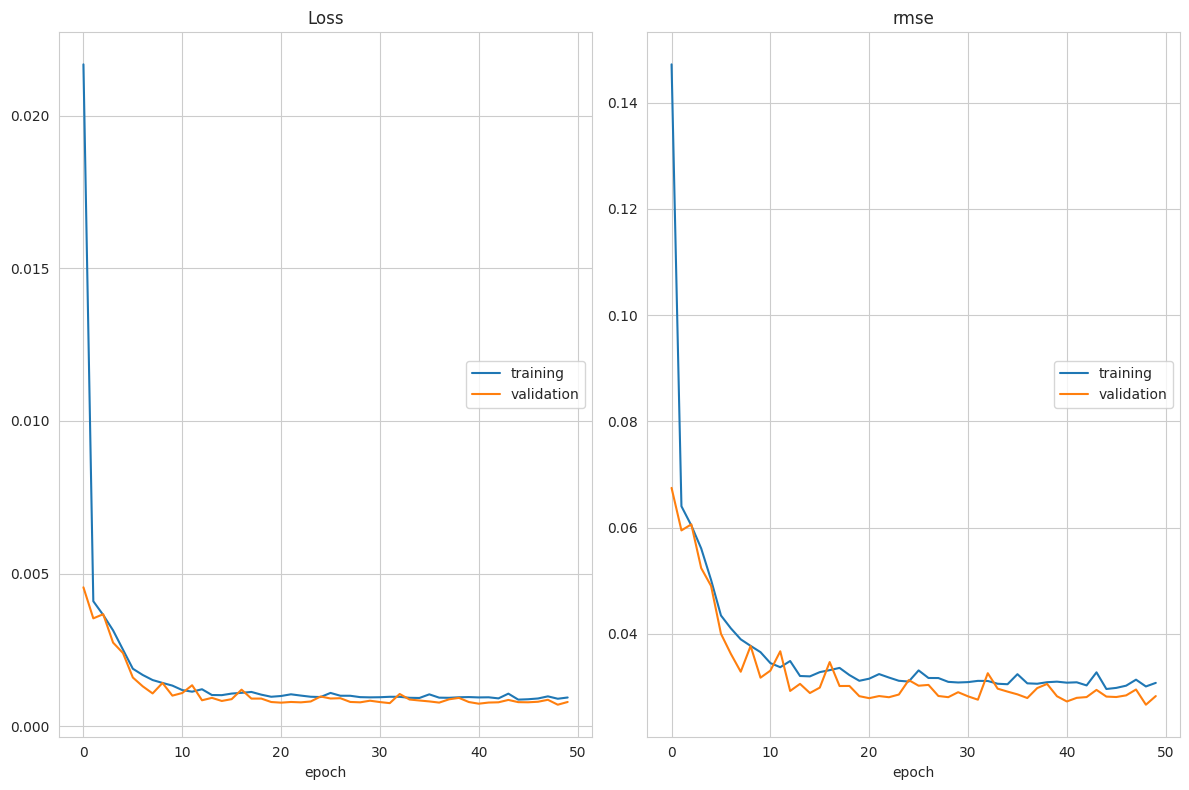

Loss
	training         	 (min:    0.001, max:    0.022, cur:    0.001)
	validation       	 (min:    0.001, max:    0.005, cur:    0.001)
rmse
	training         	 (min:    0.030, max:    0.147, cur:    0.031)
	validation       	 (min:    0.027, max:    0.067, cur:    0.028)
--- Training Complete (196.68s) ---


In [57]:
# 1. Instantiate the baseline model from the class defined in Cell 14
model_baseline = LSTMModel_Baseline(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=OUTPUT_SIZE,
    dropout_rate=DROPOUT_RATE
).to(device)

# 2. Create a new optimizer specifically for this model
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=LEARNING_RATE)

# 3. Call the reusable training function
baseline_history = train_model(
    model=model_baseline,
    optimizer=optimizer_baseline,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS
)

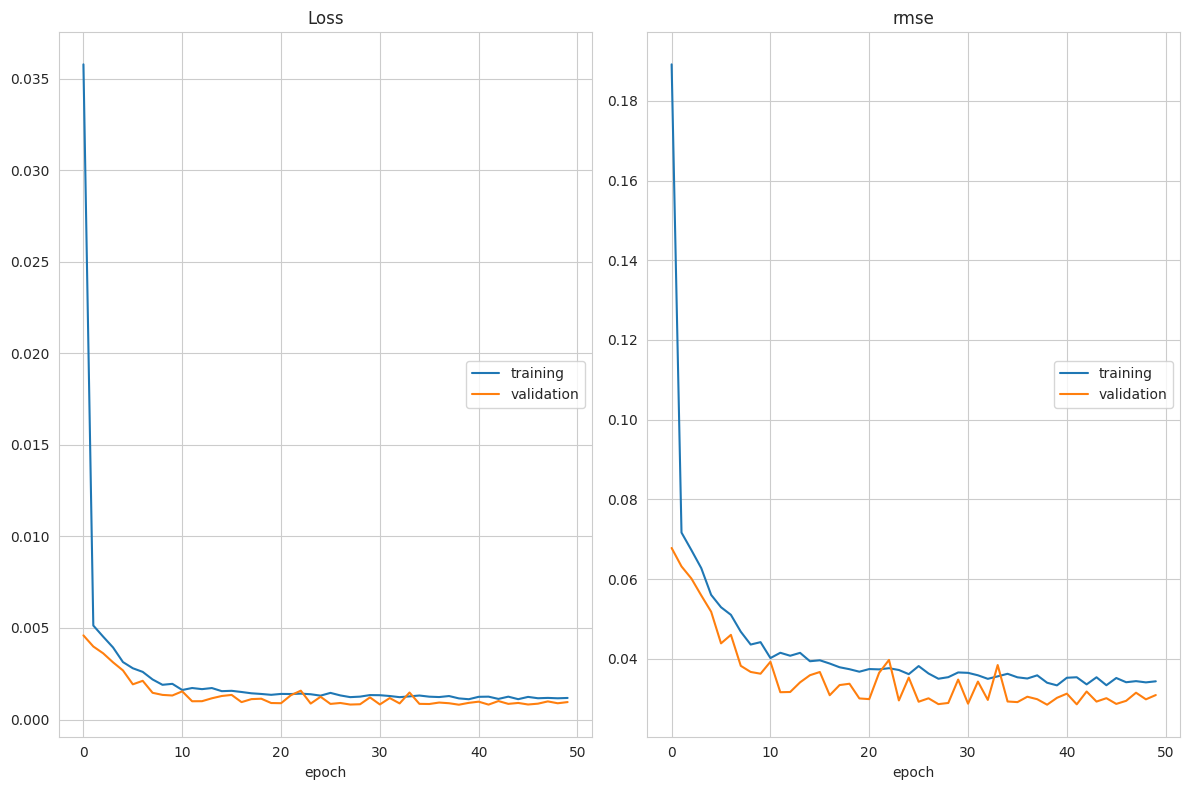

Loss
	training         	 (min:    0.001, max:    0.036, cur:    0.001)
	validation       	 (min:    0.001, max:    0.005, cur:    0.001)
rmse
	training         	 (min:    0.033, max:    0.189, cur:    0.034)
	validation       	 (min:    0.028, max:    0.068, cur:    0.031)
--- Training Complete (200.49s) ---


In [56]:

# 1. Instantiate the combined dropout model
model_dropout = LSTMModel_CombinedDropout(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=OUTPUT_SIZE,
    dropout_rate=DROPOUT_RATE
).to(device)

# 2. Create a new optimizer for the new model
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=LEARNING_RATE)

# 3. Call the reusable training function with the new model and optimizer
dropout_history = train_model(
    model=model_dropout,
    optimizer=optimizer_dropout,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS
)

baseline model did slightly better- so im going with it since its simpler.

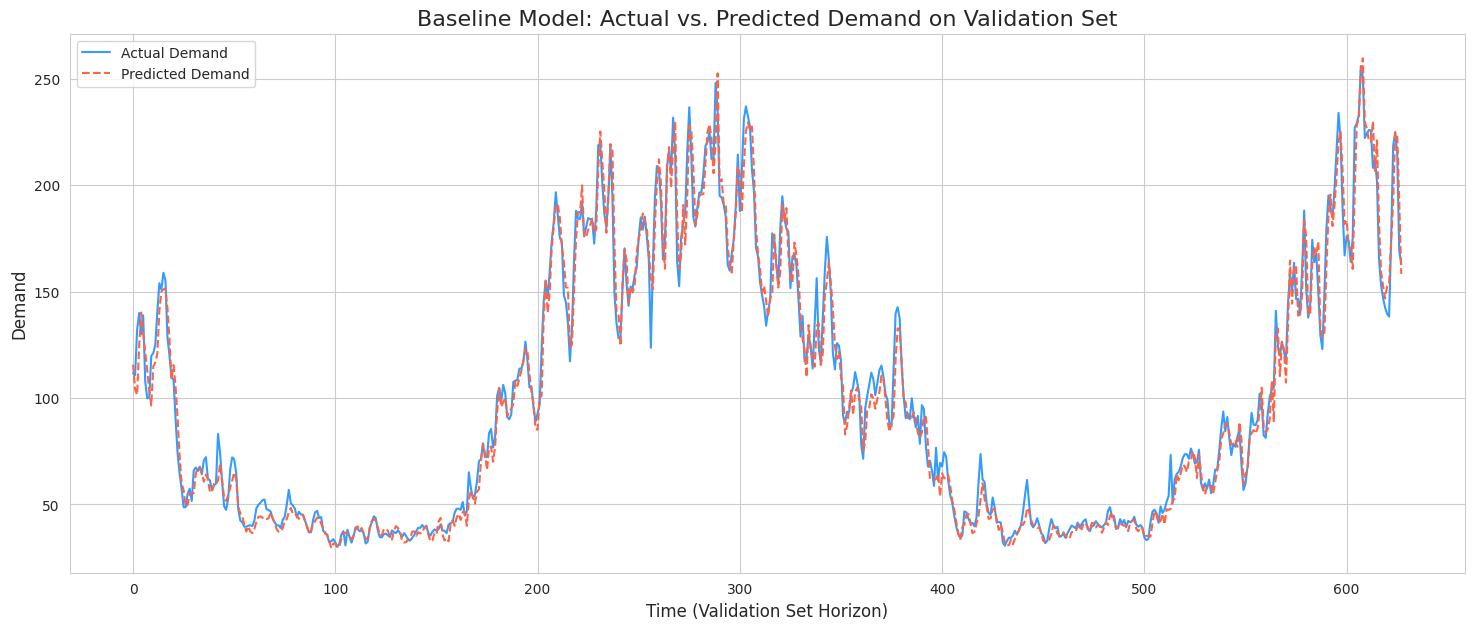

In [64]:
# 1. Set the model to evaluation mode
model_baseline.eval()

# 2. Get predictions and actuals from the validation loader
all_predictions_scaled = []
all_actuals_scaled = []

# Use torch.no_grad() for faster inference
with torch.no_grad():
    for inputs, labels in val_loader:
        # Move data to the correct device
        inputs = inputs.to(device)

        # Make predictions
        outputs = model_baseline(inputs)

        # Append batch predictions and labels to lists
        all_predictions_scaled.append(outputs.cpu().numpy())
        all_actuals_scaled.append(labels.numpy())

# Concatenate all batches into single numpy arrays
all_predictions_scaled = np.concatenate(all_predictions_scaled)
all_actuals_scaled = np.concatenate(all_actuals_scaled)

# 3. Inverse transform predictions and actuals to their original scale
target_col_index = FEATURES_TO_USE.index(TARGET_NAME)

# Inverse transform predictions
dummy_preds = np.zeros((len(all_predictions_scaled), INPUT_SIZE))
dummy_preds[:, target_col_index] = all_predictions_scaled.flatten()
inverse_predictions = scaler.inverse_transform(dummy_preds)[:, target_col_index]

# Inverse transform actuals
dummy_actuals = np.zeros((len(all_actuals_scaled), INPUT_SIZE))
dummy_actuals[:, target_col_index] = all_actuals_scaled.flatten()
inverse_actuals = scaler.inverse_transform(dummy_actuals)[:, target_col_index]

# 4. Plot the results
plt.figure(figsize=(18, 7))
plt.plot(inverse_actuals, label='Actual Demand', color='dodgerblue', alpha=0.9)
plt.plot(inverse_predictions, label='Predicted Demand', color='tomato', linestyle='--')
plt.title('Baseline Model: Actual vs. Predicted Demand on Validation Set', fontsize=16)
plt.xlabel('Time (Validation Set Horizon)', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

the model is missing the spikes but overall its generalizing quite well to the demand trend. this is happend because the model is trained to minimize the Mean Squared Error (MSE) over the entire dataset. MSE punishes large errors heavily so the learns to smooth things out. So im trying a different loss function.

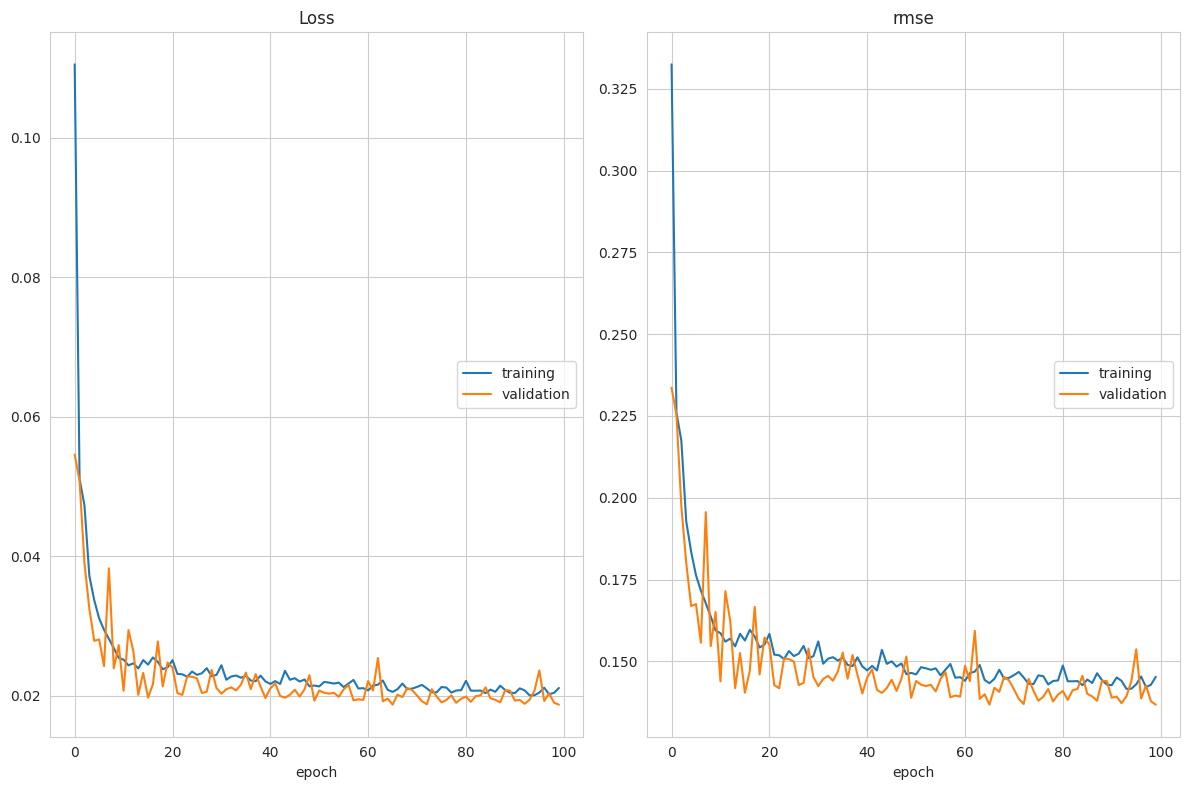

Loss
	training         	 (min:    0.020, max:    0.111, cur:    0.021)
	validation       	 (min:    0.019, max:    0.055, cur:    0.019)
rmse
	training         	 (min:    0.142, max:    0.332, cur:    0.145)
	validation       	 (min:    0.137, max:    0.234, cur:    0.137)
--- Training Complete (372.37s) ---


In [66]:
# --- 1. Define the new Loss Function ---
# PyTorch's implementation of MAE is nn.L1Loss
criterion_mae = nn.L1Loss()

# --- 2. Instantiate a new model to train from scratch ---
# It's important to use a fresh, untrained model for a fair comparison
model_mae_experiment = LSTMModel_Baseline(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=OUTPUT_SIZE,
    dropout_rate=DROPOUT_RATE
).to(device)

# --- 3. Create a new optimizer for this new model ---
optimizer_mae = torch.optim.Adam(model_mae_experiment.parameters(), lr=LEARNING_RATE)

# --- 4. Call your training function with the new criterion ---
print("--- Starting Training with MAE (L1 Loss) ---")
mae_history = train_model(
    model=model_mae_experiment,
    optimizer=optimizer_mae,
    criterion=criterion_mae,  # <-- The only change is here!
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100
)

new loss function didnt improve results even with 100 epochs - potentially because mse is quadratic so it has a curved function vs mae has a v shaped function- making it harder to find the minimum.

In [61]:
def create_sequences(data, sequence_length, target_col_index):
    """
    Converts scaled data into sequences for the LSTM model.
    This version is robust to the target column's position.
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        # Input features: a sequence of 'sequence_length' days of ALL features
        X.append(data[i-sequence_length:i, :])
        # Target: The value from the specific target column for the day after the sequence
        y.append(data[i, target_col_index])
    return np.array(X), np.array(y)

print("Robust 'create_sequences' function has been defined.")

# --- Define the necessary configuration variables again ---
FEATURES_TO_USE = [
    'demand', 'avg_temp', 'avg_temp_night', 'avg_wind',
    'avg_wind_night', 'avg_ssrd_ratio', 'day_of_year_sin',
    'month_sin', 'day_of_week_sin'
]
TARGET_NAME = 'demand'

# --- The function to prepare the test set ---
def create_full_test_set(train_df, test_df, scaler, features_to_use, target_name, sequence_length):
    print("--- Creating Full Test Set for Prediction ---")
    last_n_days_train = train_df.tail(sequence_length)
    test_df_copy = test_df.copy()
    test_df_copy[target_name] = 0
    combined_df = pd.concat([last_n_days_train, test_df_copy])
    df_processed = combined_df.copy()
    df_processed['day_of_year_sin'] = np.sin(2 * np.pi * df_processed.index.dayofyear / 365.25)
    df_processed['month_sin'] = np.sin(2 * np.pi * df_processed.index.month / 12)
    df_processed['day_of_week_sin'] = np.sin(2 * np.pi * df_processed.index.dayofweek / 7)
    final_df = df_processed[features_to_use]
    scaled_data = scaler.transform(final_df)
    target_col_index = features_to_use.index(target_name)

    X_test, _ = create_sequences(scaled_data, sequence_length, target_col_index)

    X_test = X_test[-len(test_df):]
    X_test_tensor = torch.from_numpy(X_test).float()
    print(f"Created {len(X_test_tensor)} sequences for final prediction.")
    return X_test_tensor

# --- Execute the function ---
X_test_final = create_full_test_set(
    train_df=train_df,
    test_df=test_df,
    scaler=scaler,
    features_to_use=FEATURES_TO_USE,
    target_name=TARGET_NAME,
    sequence_length=SEQUENCE_LENGTH
)

Robust 'create_sequences' function has been defined.
--- Creating Full Test Set for Prediction ---
Created 730 sequences for final prediction.


taking last 30 days from training data and adding it to test data so it can make the predictions.

In [62]:
# --- 1. Set the model to evaluation mode ---
model_baseline.eval()

# --- 2. Make Predictions on the Final Test Set ---
print("--- Making final predictions ---")
with torch.no_grad():
    # Pass the final test tensor to the model
    final_predictions_scaled = model_baseline(X_test_final.to(device))

# send predictions to the CPU and convert to a NumPy array for further processing
final_predictions_scaled = final_predictions_scaled.cpu().numpy()

# --- 3. Inverse Transform the Predictions ---
# scaling the predictions back to the original units of demand.
# created a dummy array matching the scaler's expected shape (9 features)
# and place our predictions in the correct column.

# get the index of the 'demand' column
target_col_index = FEATURES_TO_USE.index(TARGET_NAME)

# dummy array
dummy_array = np.zeros((len(final_predictions_scaled), INPUT_SIZE))
dummy_array[:, target_col_index] = final_predictions_scaled.flatten()

# apply the inverse transformation
inverse_predictions = scaler.inverse_transform(dummy_array)[:, target_col_index]
print("Predictions successfully scaled back to original demand units.")

# --- 4. Create the Submission DataFrame ---
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'demand': inverse_predictions.flatten()
})

# --- 5. Save the Results to a CSV File ---
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)

print("-" * 30)
print(f"Submission file created successfully: {submission_filename}")
print("Here are the first 5 predictions:")
print(submission_df.head())
print("-" * 30)

--- Making final predictions ---
Predictions successfully scaled back to original demand units.
------------------------------
Submission file created successfully: submission.csv
Here are the first 5 predictions:
              id      demand
date                        
2018-01-01  3289  182.659748
2018-01-02  3290  121.639167
2018-01-03  3291  110.421208
2018-01-04  3292   87.648858
2018-01-05  3293   81.500188
------------------------------


In [63]:
# The scaler was fitted on the 9 features, with 'demand' being the first one.
# We can find the original range (max - min) of the demand from the scaler's properties.
demand_col_index = FEATURES_TO_USE.index(TARGET_NAME)
demand_range = 1 / scaler.scale_[demand_col_index]

# Get the final validation RMSE from your training history
final_val_rmse_scaled = baseline_history['val_rmse'][-1]

# Unscale the RMSE
final_val_rmse_unscaled = final_val_rmse_scaled * demand_range

print(f"--- Estimated Performance ---")
print(f"Final Validation RMSE (scaled): {final_val_rmse_scaled:.4f}")
print(f"Final Validation RMSE (unscaled): {final_val_rmse_unscaled:.2f} demand units")

--- Estimated Performance ---
Final Validation RMSE (scaled): 0.0283
Final Validation RMSE (unscaled): 8.18 demand units


A result of "8.18 demand units" means that on average, the basline model's forecast for gas demand is off by about 8.18 units. If the actual demand on a given day was 150, the model might have predicted 142 or 158.